In [151]:
#install


In [152]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

### Knob

In [153]:
cardinality_threshold = 30
train_test_split_ratio = 0.2
random_state = 42
data_path = "./dataset/"

### functions

In [154]:

def plot_distribution(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

# write a plot function to show relationship continous feature and categorical target

def plot_continuous_vs_categorical(df, continuous_feature, categorical_feature):
    """
    Plots the relationship between a continuous feature and a categorical target.

    Args:
    df (DataFrame): The pandas DataFrame containing the data.
    continuous_feature (str): The name of the continuous feature column.
    categorical_feature (str): The name of the categorical target column.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categorical_feature, y=continuous_feature, data=df)
    plt.title(f'Relationship between {continuous_feature} and {categorical_feature}')
    plt.xlabel(categorical_feature)
    plt.ylabel(continuous_feature)
    plt.show()

def plot_categorical_relationship(df, categorical_feature, categorical_target):
    """
    Plots the relationship between a categorical feature and a categorical target.

    Args:
    df (DataFrame): The pandas DataFrame containing the data.
    categorical_feature (str): The name of the categorical feature column.
    categorical_target (str): The name of the categorical target column.
    """
    plt.figure(figsize=(12, 8))
    sns.countplot(x=categorical_feature, hue=categorical_target, data=df)
    plt.title(f'Relationship between {categorical_feature} and {categorical_target}')
    plt.xlabel(categorical_feature)
    plt.ylabel('Count')
    plt.legend(title=categorical_target)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
    plt.show()

### Analysis

In [155]:
df_benign_chrome = pd.read_csv(data_path + "benign-chrome.csv")
df_benign_firefox = pd.read_csv(data_path + "benign-firefox.csv")
data = pd.concat([df_benign_chrome, df_benign_firefox], axis=0)
print(data.shape)

(917300, 35)


In [156]:
# since I want analye the DoH traffic, I will drop the non-DoH traffic
data = data[data['DoH']==True].drop(columns=['DoH'])

In [157]:
unique_destination_ips = data['DestinationIP'].nunique()
print(f'There are {unique_destination_ips} unique destination IPs in the dataset.')

There are 10 unique destination IPs in the dataset.


In [158]:
# creating time based features
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])

# Extracting various time components
data['Year'] = data['TimeStamp'].dt.year
data['Month'] = data['TimeStamp'].dt.month
data['Day'] = data['TimeStamp'].dt.day
data['Hour'] = data['TimeStamp'].dt.hour
data['Minute'] = data['TimeStamp'].dt.minute
data['Second'] = data['TimeStamp'].dt.second
data['DayOfWeek'] = data['TimeStamp'].dt.dayofweek  # Monday=0, Sunday=6
data['DayOfYear'] = data['TimeStamp'].dt.dayofyear
data['WeekOfYear'] = data['TimeStamp'].dt.isocalendar().week

# drop the timestamp column
data = data.drop(columns=['TimeStamp'])


In [159]:
# Predict the destination IP address

target = 'DestinationIP'
features = data.drop(columns=['DestinationIP']).columns

In [160]:
# # one hot encoding of categorical features in features which has cardinality less than cardinality_threshold
# categorical_features = [feature for feature in features if data[feature].nunique() < cardinality_threshold]
# data = pd.get_dummies(data, columns=categorical_features, drop_first=True)


### EDA

In [161]:
# print list of columns
print(data[features].columns)

Index(['SourceIP', 'SourcePort', 'DestinationPort', 'Duration',
       'FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived',
       'FlowReceivedRate', 'PacketLengthVariance',
       'PacketLengthStandardDeviation', 'PacketLengthMean',
       'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
       'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation',
       'PacketTimeVariance', 'PacketTimeStandardDeviation', 'PacketTimeMean',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian',
       'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
       'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation',
       'ResponseTimeTimeMean', 'ResponseTimeTimeMedian',
       'ResponseTimeTimeMode', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation', 'Year', 'Month', 'Day',
       'Hour', 'Minute', 'Second', 'DayOfWeek', 'DayOfYear', 'WeekOfYear'],
      dtyp

In [162]:
# clean the data
data = data.dropna()

# drop unnecessary columns from dataset and features
list_of_columns_to_drop = ['SourceIP', 'SourcePort', 'DestinationPort']
data = data.drop(columns=list_of_columns_to_drop)
features = [feature for feature in features if feature not in list_of_columns_to_drop]

scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])


### Train and Test Models

In [163]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=train_test_split_ratio, random_state=random_state)

In [164]:
# train the model
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

                 precision    recall  f1-score   support

        1.1.1.1       0.98      0.98      0.98       260
176.103.130.130       0.95      0.98      0.97       458
176.103.130.131       0.80      0.62      0.70        26
 192.168.20.111       1.00      0.99      0.99       291
 192.168.20.112       0.99      1.00      0.99        87
 192.168.20.113       1.00      0.99      0.99        97
 192.168.20.191       1.00      0.71      0.83        24
        8.8.4.4       0.98      1.00      0.99        93
        8.8.8.8       1.00      1.00      1.00      2033
        9.9.9.9       0.99      0.99      0.99       581

       accuracy                           0.99      3950
      macro avg       0.97      0.93      0.94      3950
   weighted avg       0.99      0.99      0.99      3950

Accuracy: 0.9883544303797468


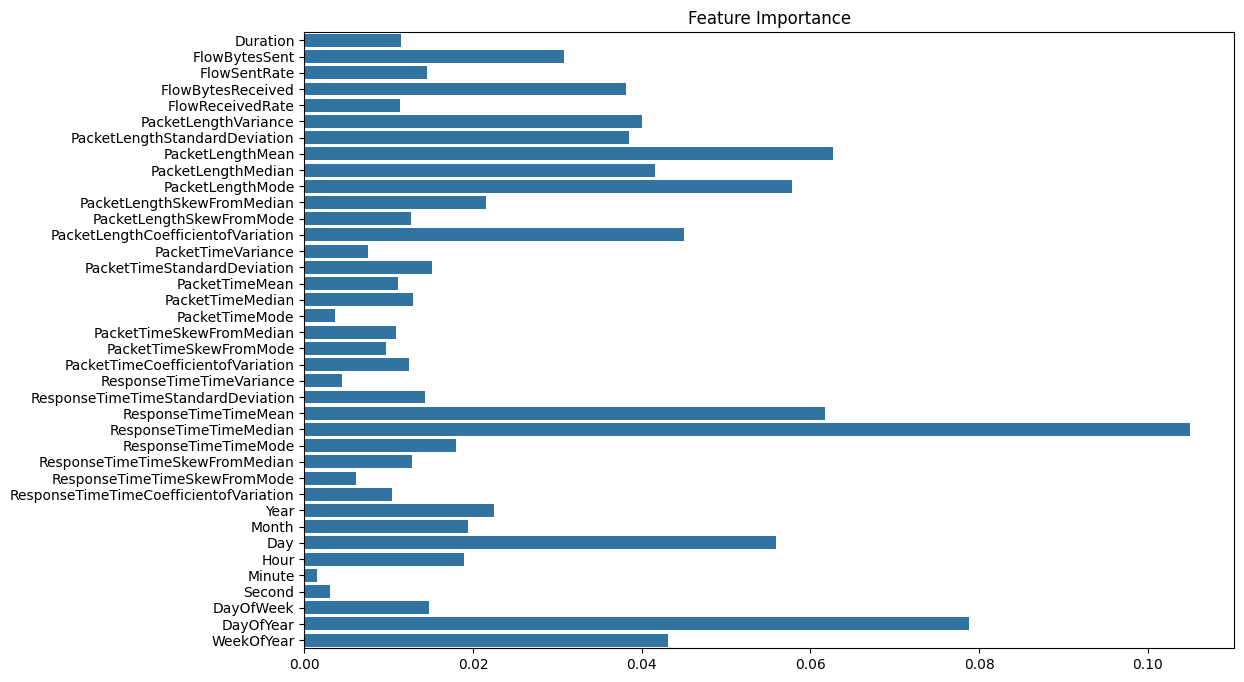

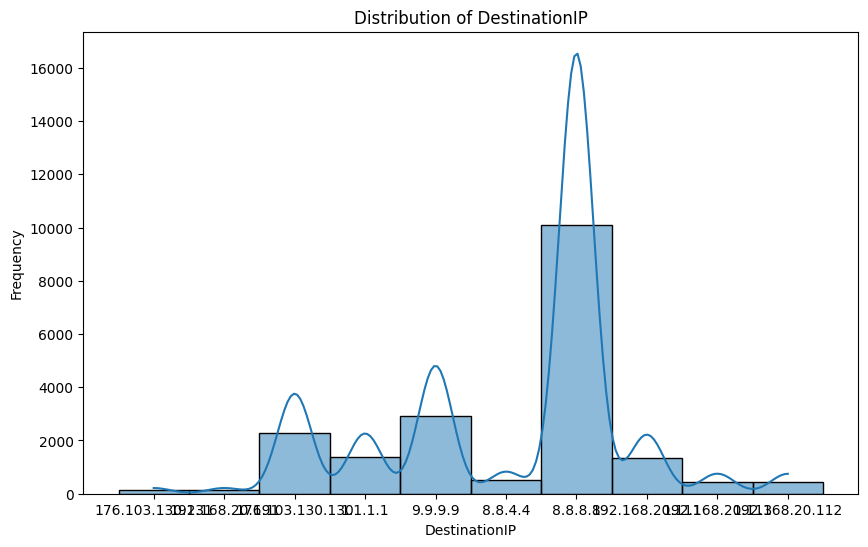

In [165]:
# make predictions
y_pred = rf.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# plot the feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=rf.feature_importances_, y=features)
plt.title('Feature Importance')

# plot the distribution of destination IPs
plot_distribution(data, 'DestinationIP')
